# Introduction
---

## Data Diri

Nama : Arif Imam Fauzi

Batch: 30 RMT

## Objective

Pada tugas GC kali ini, peserta akan diuji mengenai pemahaman *Computer Vision*/*NLP* dan peserta dibebaskan untuk memilih salah satunya. Saya memutuskan untuk mengambil *Computer Vision* beserta metode *ANN* yang digunakannya. Dataset yang saya gunakan adalah gambar tanaman padi yang memiliki penyakit (ada 3 kelas). Dari gambar tersebut akan dibuat pemodelan untuk menentukan penyakit apa yang menjangkiti tanaman tersebut melalui gambar yang diberikan.

# Import Libraries
---

Untuk library yang akan digunakan di-*import* pada bagian ini.

In [1]:
import os
import glob
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from shutil import copyfile
from PIL import Image
from pathlib import Path
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import classification_report


!pip install -q kaggle
!wget https://raw.githubusercontent.com/FTDS-learning-materials/phase-2/master/w1/P2W1D3AM%20-%20Computer%20Vision%20-%20kaggle.json -O kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

--2024-05-20 16:06:28--  https://raw.githubusercontent.com/FTDS-learning-materials/phase-2/master/w1/P2W1D3AM%20-%20Computer%20Vision%20-%20kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      74  --.-KB/s    in 0s      

2024-05-20 16:06:28 (7.10 MB/s) - ‘kaggle.json’ saved [74/74]

kaggle.json
total 4
-rw------- 1 root root 74 May 20 16:06 kaggle.json
{"username":"fahmiimanalfarizki","key":"47da5e900d616ba7923f8edb186a93c4"}

# Data Loading
---

Dataset akan dimuat disini dan akan dilakukan beberapa pemeriksaan sederhana terkait informasi didalamnya.

In [2]:
# download dataset

!kaggle datasets download -d jay7080dev/rice-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/jay7080dev/rice-plant-diseases-dataset
License(s): Apache 2.0
 96% 169M/176M [00:05<00:00, 39.1MB/s]
100% 176M/176M [00:05<00:00, 34.8MB/s]


In [3]:
# unzip dataset

!unzip -q /content/rice-plant-diseases-dataset.zip

In [4]:
# dibuat list image dari setiap kategori

bb_dis = glob.glob('/content/rice leaf diseases dataset/Bacterialblight/*')
bs_dis = glob.glob('/content/rice leaf diseases dataset/Brownspot/*')
ls_dis = glob.glob('/content/rice leaf diseases dataset/Leafsmut/*')

## Total Dataset

In [5]:
print(f'Total dataset ialah: {len(ls_dis) + len(bb_dis) + len(bs_dis)} gambar')

Total dataset ialah: 4684 gambar


## Ukuran Setiap *Image*

In [6]:
# kita lihat semua ukuran kategori

def size_img(cat_1, cat_2, cat_3):
  # list untuk menampung ukuran setiap gambar
  size_cat_1 = []
  size_cat_2 = []
  size_cat_3 = []

  # looping untuk membuka gambar dan mengambil ukuran image
  for img_idx in cat_1:
    img = Image.open(img_idx)
    size_cat_1.append(img.size)

  for img_idx in cat_2:
    img = Image.open(img_idx)
    size_cat_2.append(img.size)

  for img_idx in cat_3:
    img = Image.open(img_idx)
    size_cat_3.append(img.size)

  # return untuk mengembalikan nilai
  return set(size_cat_1), set(size_cat_2), set(size_cat_3)

In [7]:
# gunakan function untuk melihat ukuran image

size_bb_dis, size_bs_dis, size_ls_dis = size_img(bb_dis, bs_dis, ls_dis)
print(f'Ukuran image kategori Bacterial Blight: {size_bb_dis}')
print(f'Ukuran image kategori Brownspot: {size_bs_dis}')
print(f'Ukuran image kategori Leafsmut: {size_ls_dis}')

Ukuran image kategori Bacterial Blight: {(300, 300)}
Ukuran image kategori Brownspot: {(300, 300)}
Ukuran image kategori Leafsmut: {(300, 300)}


Setelah diperiksa, hasil yang didapat yaitu:
* Dataset ini terbagi menjadi 3 kelas penyakit yaitu *Bacterial Blight*, *Brownspot* dan *Leafsmut*.
* Total datasetnya sebanyak 4684 *image*.
* Kebetulan, semua *image* berukuran sama yaitu 300x300.

# Exploratory Data Analysis
---

## Warna dan Bentuk

Dari dataset *image* ini, akan dieksplorasi mengenai ciri khas warna dan bentuknya melalui *visual human*.

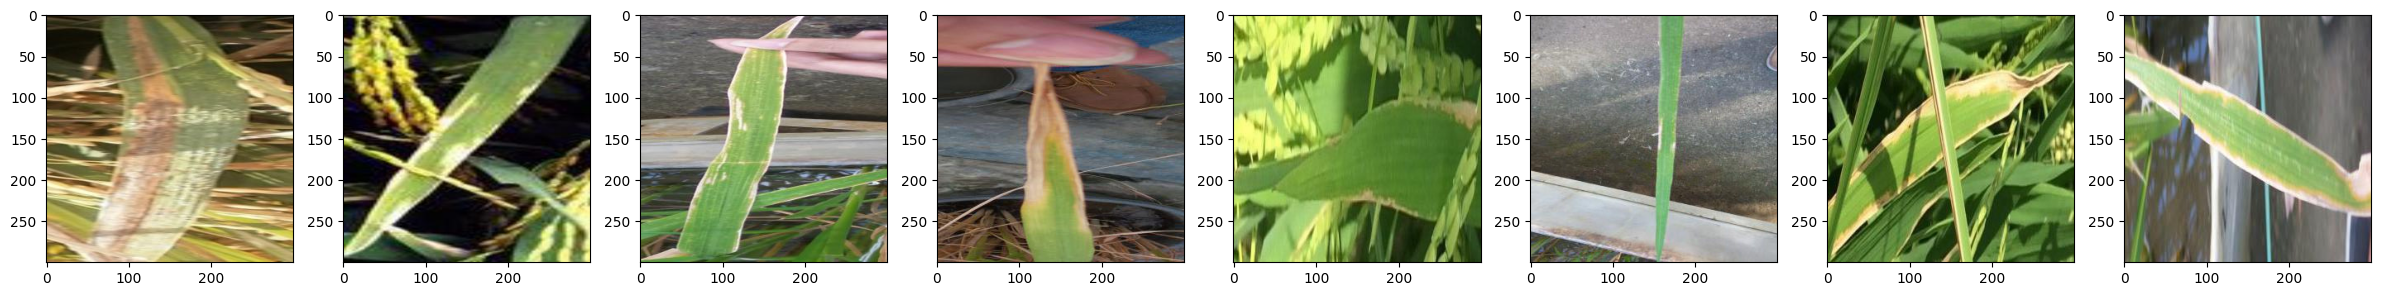

In [8]:
# ini isi image dari kategori penyakit Bacterialblight

fig, ax = plt.subplots(ncols=8, figsize=(30,5))
for i in range(8):
  bb = plt.imread(bb_dis[i])
  ax[i].imshow(bb)

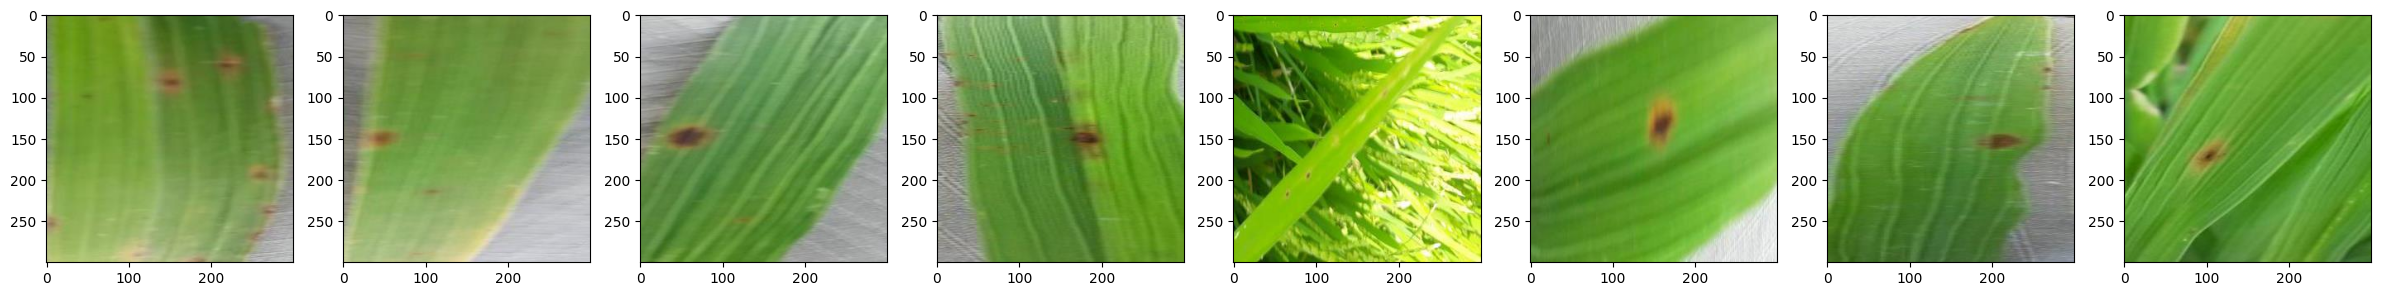

In [9]:
# ini isi image dari kategori penyakit Brownspot

fig, ax = plt.subplots(ncols=8, figsize=(30,5))
for i in range(8):
  bs = plt.imread(bs_dis[i])
  ax[i].imshow(bs)

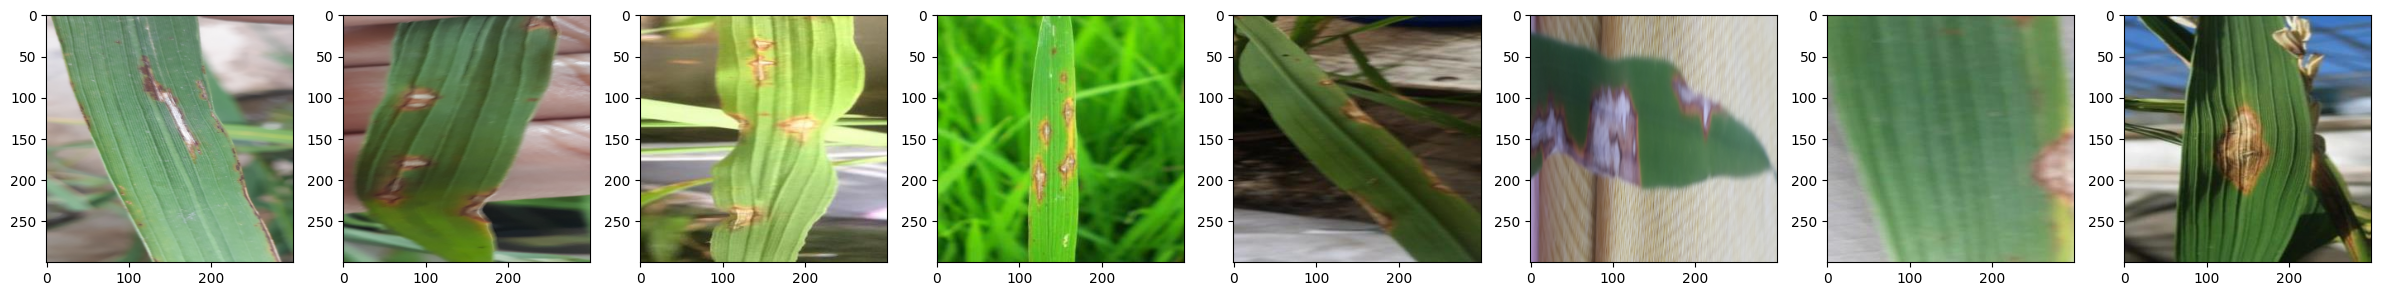

In [10]:
# ini isi image dari kategori penyakit Leafsmut

fig, ax = plt.subplots(ncols=8, figsize=(30,5))
for i in range(8):
  ls = plt.imread(ls_dis[i])
  ax[i].imshow(ls)

Berdasarkan warna dan bentuk secara *human eye*, bisa disimpulkan bahwa:
* Penyakit *Bacterial Blight* memiliki ciri khas warna kuning atau coklat yang berbentuk membujur/vertikal pada daun tanaman padi. Letaknya bisa dipinggir daun, tengah atau keduanya.
* Penyakit *Brownspot* memiliki ciri khas seperti berbentuk lingkaran dengan bagian luarnya berwarna coklat atau kuning sementara bagian dalamnya cenderung berwarna gelap (bisa dikatakan hitam).
* Penyakit *Leafsmut* sendiri memiliki ciri yang mirip dengan *Brownspot* namun bedanya dibagian tengah tidak gelap dan malah cenderung lebih terang dari warna luarnya seperti bagian tersebut sudah mengering lebih awal (bahkan ada yang sudah bolong).

## Ukuran

Kebetulan saya sudah bahas ini ketika **Data Loading** dan kebetulan juga semua gambarnya memiliki ukuran yang sama yaitu 300x300.

## Ruang Warna

Untuk memeriksa karakteristik warna pada dataset ini, akan dicoba menggunakan beberapa perubahan warna dengan harapan bisa terlihat apa perbedaan dari setiap kelas jika dilakukan pengubahan ruang warna.

In [11]:
# buat function untuk mencoba beberapa perubahan warna

def color_space(image):
  # definisikan ukuran
  plt.figure(figsize=(16, 6))

  # ambil angka acak sebagai indeks
  idx = random.randint(0, len(image))

  # plot pertama menggunakan RGB
  plt.subplot(1, 7, 1)
  bb = cv2.imread(image[idx])
  bb = cv2.cvtColor(bb, cv2.COLOR_BGR2RGB)
  plt.title('RGB')
  plt.imshow(bb)

  # plot kedua menggunakan Grayscale
  plt.subplot(1, 7, 2)
  bb_gray = cv2.cvtColor(bb, cv2.COLOR_RGB2GRAY)
  plt.title('Gray')
  plt.imshow(bb_gray)

  # plot ketiga menggunakan HSV
  plt.subplot(1, 7, 3)
  bb_hsv = cv2.cvtColor(bb, cv2.COLOR_RGB2HSV)
  plt.title('HSV')
  plt.imshow(bb_hsv)

  # plot keempat menggunakan HLS
  plt.subplot(1, 7, 4)
  bb_hls = cv2.cvtColor(bb, cv2.COLOR_RGB2HLS)
  plt.title('HLS')
  plt.imshow(bb_hls)

  # plot kelima menggunakan LAB
  plt.subplot(1, 7, 5)
  bb_lab = cv2.cvtColor(bb, cv2.COLOR_RGB2LAB)
  plt.title('LAB')
  plt.imshow(bb_lab)

  # plot keenam menggunakan XYZ
  plt.subplot(1, 7, 6)
  bb_xyz = cv2.cvtColor(bb, cv2.COLOR_RGB2XYZ)
  plt.title('XYZ')
  plt.imshow(bb_xyz)

  # plot ketujuh menggunakan YCrCb
  plt.subplot(1, 7, 7)
  bb_ycr = cv2.cvtColor(bb, cv2.COLOR_RGB2YCrCb)
  plt.title('YCrCb')
  plt.imshow(bb_ycr)

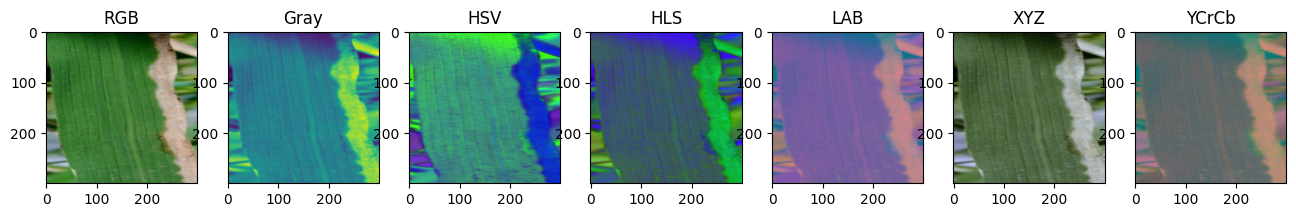

In [12]:
# tampilan untuk kelas Bacterial Blight

color_space(bb_dis)

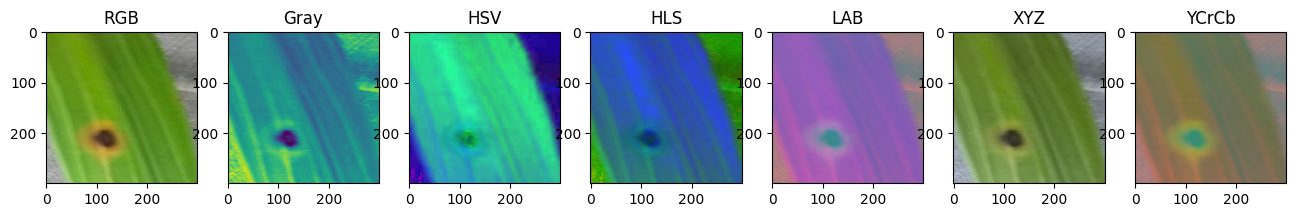

In [13]:
# tampilan untuk kelas Brownspot

color_space(bs_dis)

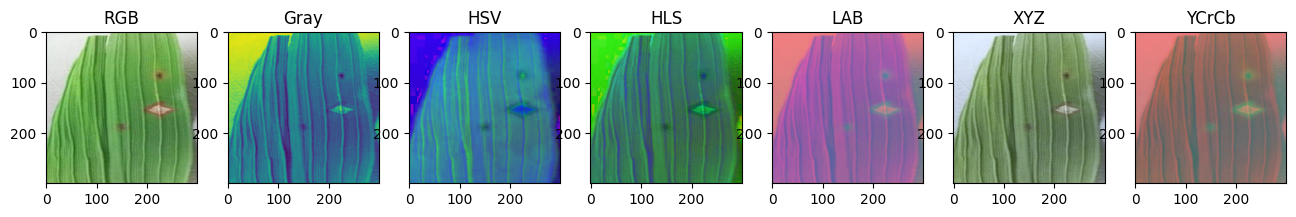

In [14]:
# tampilan untuk kelas Leafsmut

color_space(ls_dis)

Dari beberapa percobaan yang saya temukan, berikut hasilnya:
* Bagi saya, sulit untuk mengatakan perubahan warna mana yang paling cocok untuk melihat karakteristik ketiga kelas penyakit ini jika menggunakan *visual human*. Kadang ada kelas yang cocok dengan satu perubahan warna, tetapi di kelas lain tidak begitu bagus.
* Setelah melakukan percobaan beberapa kali, setidaknya saya menemukan 2 hal yang mempengaruhi perubahan warna apa yang cocok untuk tiap kelasnya dalam mengidentifikasi karakteristik warnanya. Pertama, luasan area daun yang terserang penyakit dan kedua, bagaimana kontras cahaya disekitar gambar penyakitnya.
* Untuk penyakit *Bacterial Blight*, karena luasan area yang terserang penyakit lebih besar dari 2 kelas penyakit lainnya, semua perubahan tipe warna menunjukkan hasil yang cukup bagus dalam mengidentifikasi karakteristik warna penyakitnya.
* Untuk penyakit *Brownspot*, saya cenderung menyukai pemakaian *LAB* atau *YCrCb*. Mirip dengan *Brownspot*, namun untuk penyakit *Leafsmut* saya cenderung lebih mudah memahami dengan *YCrCb*.

## Sudut Pandang

*Angle* dalam *image* akan diperiksa terkait bagaimana letak/posisi penyakit tersebut tampak.

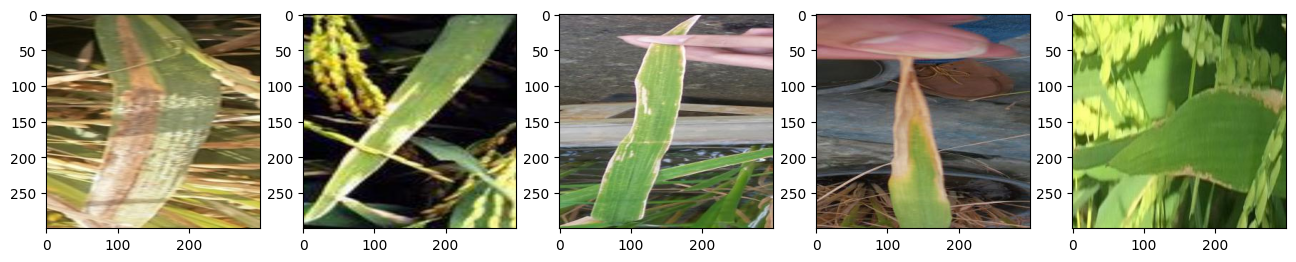

In [15]:
# image penyakit Bacterialblight

fig, ax = plt.subplots(ncols=5, figsize=(16,8))
for i in range(5):
  bb = plt.imread(bb_dis[i])
  ax[i].imshow(bb)

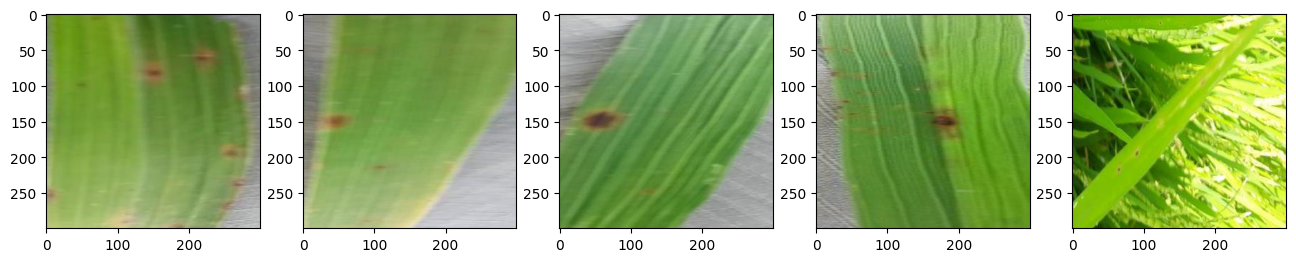

In [16]:
# ini isi image dari kategori penyakit Brownspot

fig, ax = plt.subplots(ncols=5, figsize=(16,8))
for i in range(5):
  bs = plt.imread(bs_dis[i])
  ax[i].imshow(bs)

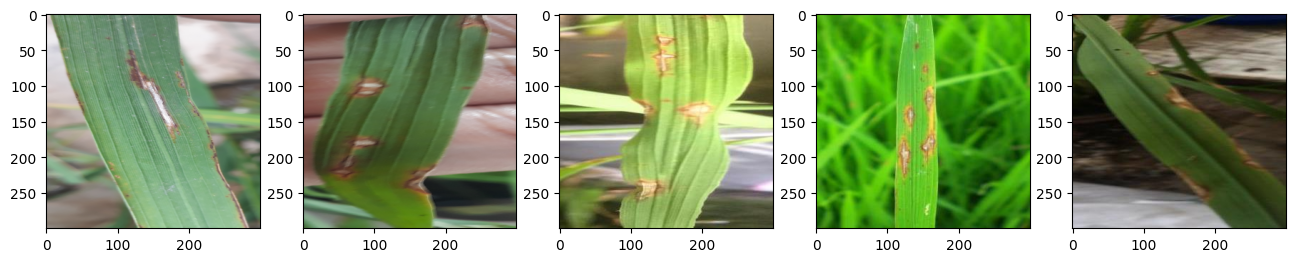

In [17]:
# ini isi image dari kategori penyakit Leafsmut

fig, ax = plt.subplots(ncols=5, figsize=(16,8))
for i in range(5):
  ls = plt.imread(ls_dis[i])
  ax[i].imshow(ls)

Terkait hasil eksplorasi ini, yang dapat saya simpulkan yaitu:
* Sudut pandang pengambilan gambar penyakit pada tanaman ini selalu dari **arah depan** (mungkin lebih tepatnya **atas**).
* Setelah beberapa kali pengecekan, <u>ada beberapa gambar yang sama dalam satu kelas namun dengan rotasi yang berbeda</u>. Mungkin saja, saya mengasumsikan bahwa data lainnya di kelas yang berbeda pun punya kemungkinan yang sama.
* Meskipun semua gambar diambil dari depan/atas, **tidak semua gambar memiliki citra yang bagus** (mungkin lebih tepatnya blur). Dengan ini juga, saya mengasumsikan hal tersebut kemungkinan bisa terjadi pada kelas lainnya.

## Noise

Ketika dalam bahasan warna dan bentuk, saya menyadari beberapa hal yang mungkin bisa mempengaruhi pemodelan.
1. Ada *image* yang diambil isinya hanya satu lembar daun dan ditempat terpisah. Ini tentu sangat menguntungkan karena dari segi warna sendiri cukup jauh berbeda dengan sekitarnya.
2. Ada *image* yang diambil ketika *user* berada di ladang. Meskipun dia tetap fokuskan untuk memfoto satu daun yang terserang penyakit itu, namun keberadaan daun-daun atau tanaman lainnya yang berada dalam satu *frame* tersebut mungkin saja bisa mempengaruhi proses *modeling*.
3. Saya tidak bisa memastikan berapa banyak data yang difoto dengan dua kondisi diatas karena datanya sendiri hampir 5000.

# Feature Engineering
---

Dibagian ini, dataset akan disiapkan untuk masuk ke pemodelan. Secara garis besar mungkin hanya akan melakukan *spliting* data, *augmentation image* (diputar horizontal/vertikal, derajat rotasi).

## Data Augmentation

Dikarenakan datanya tidak terbagi secara default ketika diambil dari *Kaggle*, maka akan dipecah secara manual.

In [18]:
# samakan nama setiap kelas

num = 1
for bb in bb_dis:
  os.rename(bb, '/content/rice leaf diseases dataset/Bacterialblight/bacterialblight_' + "{:04d}".format(num) + '.jpg')
  num += 1

num = 1
for bs in bs_dis:
  os.rename(bs, '/content/rice leaf diseases dataset/Brownspot/brownspot_' + "{:04d}".format(num) + '.jpg')
  num += 1

num = 1
for ls in ls_dis:
  os.rename(ls, '/content/rice leaf diseases dataset/Leafsmut/leafsmut_' + "{:04d}".format(num) + '.jpg')
  num += 1

In [19]:
# dibuat list image dari setiap kategori

bb_dis = glob.glob('/content/rice leaf diseases dataset/Bacterialblight/*')
bs_dis = glob.glob('/content/rice leaf diseases dataset/Brownspot/*')
ls_dis = glob.glob('/content/rice leaf diseases dataset/Leafsmut/*')

In [20]:
# buat dataframe yang berisi path datasetnya beserta label setiap image nya

all_files = bb_dis + bs_dis + ls_dis
labels = ['bacterialblight' for i in range(len(bb_dis))] + ['brownspot' for i in range(len(bs_dis))] + ['leafsmut' for i in range(len(ls_dis))]
df_rice_dis = pd.DataFrame({'images': all_files, 'label': labels})
df_rice_dis = df_rice_dis.sample(frac=1).reset_index(drop=True)
df_rice_dis

images            label
0     /content/rice leaf diseases dataset/Brownspot/...        brownspot
1     /content/rice leaf diseases dataset/Bacterialb...  bacterialblight
2     /content/rice leaf diseases dataset/Bacterialb...  bacterialblight
3     /content/rice leaf diseases dataset/Brownspot/...        brownspot
4     /content/rice leaf diseases dataset/Leafsmut/l...         leafsmut
...                                                 ...              ...
4679  /content/rice leaf diseases dataset/Bacterialb...  bacterialblight
4680  /content/rice leaf diseases dataset/Brownspot/...        brownspot
4681  /content/rice leaf diseases dataset/Bacterialb...  bacterialblight
4682  /content/rice leaf diseases dataset/Bacterialb...  bacterialblight
4683  /content/rice leaf diseases dataset/Leafsmut/l...         leafsmut

[4684 rows x 2 columns]

In [21]:
# bagi DataFrame menjadi dua bagian (train 70% dan test 30%)

train_val_df = df_rice_dis.iloc[:int(0.7 * len(df_rice_dis))]
test_df = df_rice_dis.iloc[int(0.7 * len(df_rice_dis)):]
train_val_df.shape

(3278, 2)

In [22]:
# definisikan path untuk folder baru

base_dir = '/content/dataset'
train_val_path = os.path.join(base_dir, 'train_val_set')
test_path = os.path.join(base_dir, 'test_set')
os.makedirs(train_val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

In [23]:
# salin gambar ke folder yang sudah dibuat

def copy_images(df, destination_dir):
    for index, row in df.iterrows():
      image_path = row['images']
      image_name = os.path.basename(image_path)
      class_name = row['label']
      class_dir = os.path.join(destination_dir, class_name)
      os.makedirs(class_dir, exist_ok=True)
      destination_path = os.path.join(class_dir, image_name)
      copyfile(image_path, destination_path)

# salin gambar ke dalam folder train_val
copy_images(train_val_df, train_val_path)

# salin gambar ke dalam folder test
copy_images(test_df, test_path)

## Split Data

In [25]:
# atur parameter untuk generator gambar

batch_size = 128
image_size = (300, 300)

# path
train_path = "/content/dataset/train_val_set"
test_path = "/content/dataset/test_set/"

In [24]:
# buat generator untuk data image dengan putaran horizontal dan vertikal serta rescale

train_val_gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.4
    )

Untuk **Data Augmentation** disini, saya hanya menerapkan *rescale*, horizontal dan vertikal flip serta membagi nya dengan 30% sebagai *test* (70% sisanya akan dipecah lagi menjadi *train* dan *validation*).

In [26]:
# dataset dipecah menjadi train dan test dengan perbandingan 70:30

train_set = train_val_gen.flow_from_directory(train_val_path,
                                              target_size = image_size,
                                              class_mode = 'sparse',
                                              subset = 'training',
                                              batch_size = batch_size,
                                              shuffle = True,
                                              seed = 2)

val_set = train_val_gen.flow_from_directory(train_val_path,
                                            target_size = image_size,
                                            class_mode = 'sparse',
                                            subset = 'validation',
                                            batch_size = batch_size,
                                            shuffle = True,
                                            seed = 2)

test_gen = ImageDataGenerator(rescale=1./255.)

test_set = test_gen.flow_from_directory(test_path,
                                        target_size = image_size,
                                        class_mode = 'sparse',
                                        batch_size = batch_size,
                                        shuffle = False,
                                        seed = 2)

Found 1969 images belonging to 3 classes.
Found 1309 images belonging to 3 classes.
Found 1406 images belonging to 3 classes.


In [27]:
# cek kategorinya

print(train_set.class_indices)
print(test_set.class_indices)

{'bacterialblight': 0, 'brownspot': 1, 'leafsmut': 2}
{'bacterialblight': 0, 'brownspot': 1, 'leafsmut': 2}


# ANN Training (Sequential API)
---

## Model Definition

Untuk percobaan kasus ini, saya gunakan 3 *Convolution Layer* dengan *filter* 3x3 dan 1 *Dense* diakhir

In [33]:
# bersihkan session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [34]:
# saya pilih menggunakan Sequential API

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

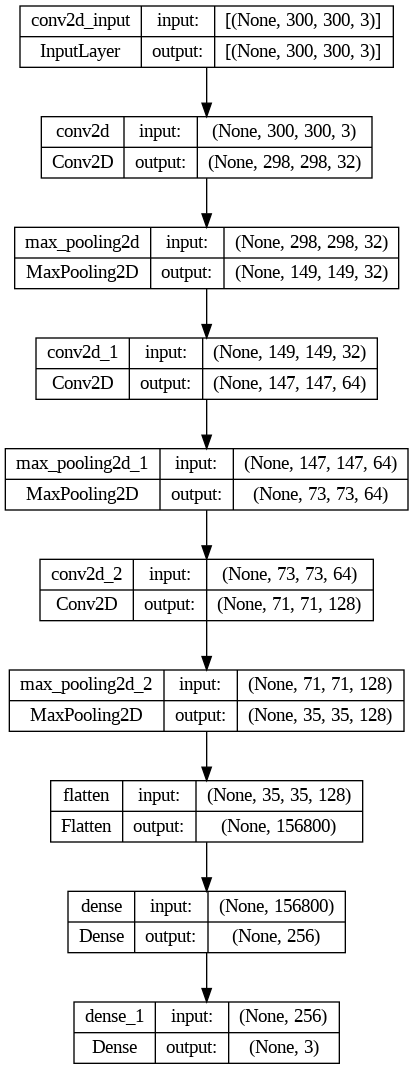

In [35]:
# plot layer yang digunakan

tf.keras.utils.plot_model(model, show_shapes=True)

## Model Training

In [36]:
# uji train model

%%time
history = model.fit(train_set, epochs = 20, validation_data = val_set, batch_size = batch_size)

Epoch 1/20
16/16 [==============================] - 39s 2s/step - loss: 1.9832 - accuracy: 0.4195 - val_loss: 0.8863 - val_accuracy: 0.5989
Epoch 2/20
16/16 [==============================] - 14s 896ms/step - loss: 0.8198 - accuracy: 0.6628 - val_loss: 0.8450 - val_accuracy: 0.6585
Epoch 3/20
16/16 [==============================] - 14s 890ms/step - loss: 0.6791 - accuracy: 0.7435 - val_loss: 0.5688 - val_accuracy: 0.7960
Epoch 4/20
16/16 [==============================] - 14s 896ms/step - loss: 0.4883 - accuracy: 0.8344 - val_loss: 0.4259 - val_accuracy: 0.8442
Epoch 5/20
16/16 [==============================] - 15s 967ms/step - loss: 0.3948 - accuracy: 0.8527 - val_loss: 0.4209 - val_accuracy: 0.8304
Epoch 6/20
16/16 [==============================] - 15s 919ms/step - loss: 0.3288 - accuracy: 0.8852 - val_loss: 0.3412 - val_accuracy: 0.8816
Epoch 7/20
16/16 [==============================] - 15s 926ms/step - loss: 0.2400 - accuracy: 0.9177 - val_loss: 0.2493 - val_accuracy: 0.9060
Ep

* Jika dilihat dari hasil *training*, baik data *train* atau *validation* memiliki akurasi yang cukup tinggi (mendekati 100%) dengan *Loss function* yang kecil.
* Sebelumnya sudah dicoba menggunakan *convolution layer* dari besar ke kecil, namun entah kenapa jadinya *error*. Maka dari itu, saya tetap menggunakan dari kecil ke besar.

## Model Evaluation

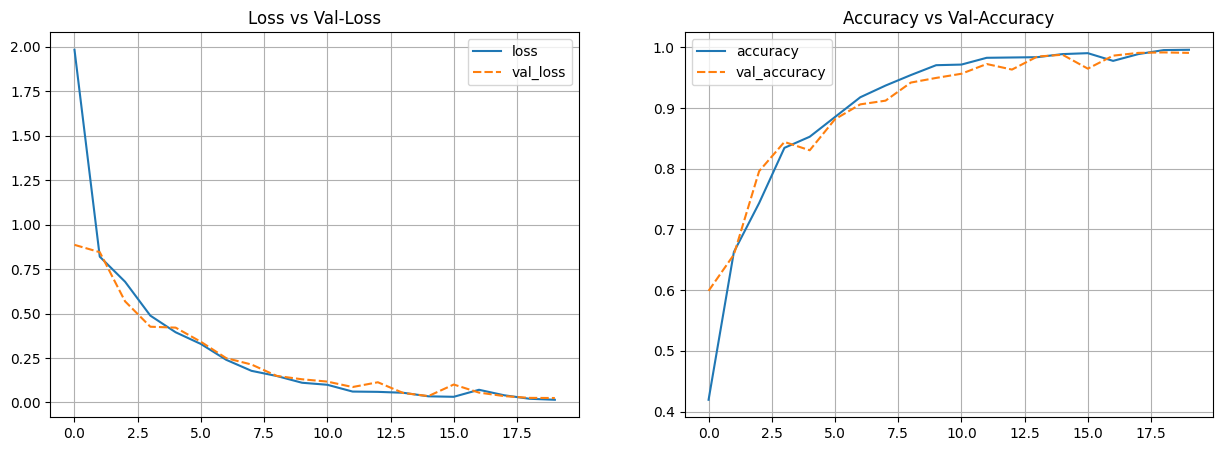

In [37]:
# plot hasil training

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [38]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(test_set.class_indices.keys()))))

                 precision    recall  f1-score   support

bacterialblight       1.00      0.99      0.99       490
      brownspot       1.00      1.00      1.00       483
       leafsmut       0.99      1.00      0.99       433

       accuracy                           0.99      1406
      macro avg       0.99      0.99      0.99      1406
   weighted avg       0.99      0.99      0.99      1406



Beberapa hal yang dapat disimpulkan dari hasil *training* dan prediksi yaitu:
* Kalau mengacu hasil *training*, bahkan nilai *Loss* (rendah) dan akurasinya (tinggi) bisa dikatakan hasilnya sangat baik dalam membaca data dengan baik. Ketika diterapkan dalam data *test*, hasilnya juga cukup memuaskan.
* Baik dari nilai *f1-score* dan akurasinya, memberikan nilai yang sangat bagus.

# ANN Improvement (Sequential API)
---

Setelah percobaan dengan pembuatan model secara manual, kini akan dilakukan percobaan menggunakan *transfer learning*. Teknik yang akan diadopsi adalah **VGG16** yang berorientasi dalam deteksi objek. Aturan yang diterapkan hanya pengubahan ukuran gambar (224x224) dan tidak perlu rescale. Ditambah nanti ruang warna akan diubah dari RGB ke BGR dengan `prepocess_input`.

In [39]:
# buat parameter baru menyesuaikan transfer learning yang digunakan

img_height = 224
img_width = 224
batch_size = 256

In [40]:
# download pretrained model

from keras.applications.vgg16 import VGG16, preprocess_input

pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
pretrained_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [41]:
# buat generator baru

train_val_gen_tl = ImageDataGenerator(horizontal_flip=True,
                                      vertical_flip=True,
                                      validation_split=0.4,
                                      preprocessing_function = preprocess_input
                                      )

test_gen_tl = ImageDataGenerator(preprocessing_function = preprocess_input)

In [48]:
# dataset dipecah menjadi train dan test dengan perbandingan 70:30

train_set_tl = train_val_gen_tl.flow_from_directory(train_val_path,
                                                    target_size = (img_height, img_width),
                                                    class_mode = 'sparse',
                                                    subset = 'training',
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    seed = 2)

val_set_tl = train_val_gen_tl.flow_from_directory(train_val_path,
                                                  target_size = (img_height, img_width),
                                                  class_mode = 'sparse',
                                                  subset = 'validation',
                                                  batch_size = batch_size,
                                                  shuffle = True,
                                                  seed = 2)

test_set_tl = test_gen_tl.flow_from_directory(test_path,
                                              target_size = (img_height, img_width),
                                              class_mode = 'sparse',
                                              batch_size = batch_size,
                                              shuffle = False,
                                              seed = 2)

Found 1969 images belonging to 3 classes.
Found 1309 images belonging to 3 classes.
Found 1406 images belonging to 3 classes.


## Model Definition

In [49]:
# bersihkan session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [50]:
# buat sequential API model baru dengan transfer learning

model_tl = Sequential()
model_tl.add(pretrained_model)
model_tl.add(Flatten())
model_tl.add(Dense(256, activation='relu'))
model_tl.add(Dense(3, activation='softmax'))

# di compile
model_tl.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21138243 (80.64 MB)
Trainable params: 6423555 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


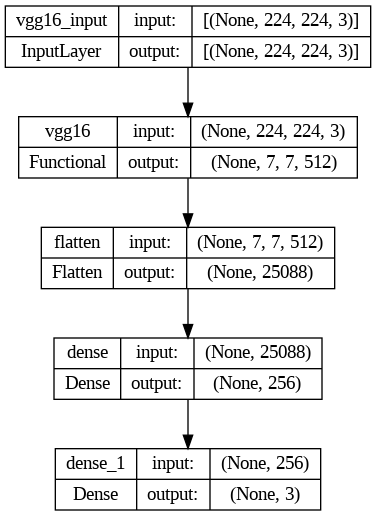

In [51]:
# plot layer

tf.keras.utils.plot_model(model_tl, show_shapes=True)

## Model Training

In [52]:
# train model dengan transfer learning yang sudah dimasukkan

%%time
history_tl = model_tl.fit(train_set_tl, epochs=20, validation_data = val_set_tl, batch_size = batch_size)

Epoch 1/20
8/8 [==============================] - 96s 7s/step - loss: 18.6635 - accuracy: 0.5952 - val_loss: 5.0642 - val_accuracy: 0.7716
Epoch 2/20
8/8 [==============================] - 17s 2s/step - loss: 1.6385 - accuracy: 0.8700 - val_loss: 0.6192 - val_accuracy: 0.9114
Epoch 3/20
8/8 [==============================] - 21s 3s/step - loss: 0.4106 - accuracy: 0.9279 - val_loss: 0.2897 - val_accuracy: 0.9305
Epoch 4/20
8/8 [==============================] - 16s 2s/step - loss: 0.1000 - accuracy: 0.9751 - val_loss: 0.1078 - val_accuracy: 0.9702
Epoch 5/20
8/8 [==============================] - 19s 2s/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.0259 - val_accuracy: 0.9939
Epoch 6/20
8/8 [==============================] - 20s 3s/step - loss: 0.0196 - accuracy: 0.9944 - val_loss: 0.0204 - val_accuracy: 0.9962
Epoch 7/20
8/8 [==============================] - 16s 2s/step - loss: 0.0099 - accuracy: 0.9980 - val_loss: 0.0135 - val_accuracy: 0.9969
Epoch 8/20
8/8 [=================

* Jika dibandingkan dengan *training* model awal, hasil model dengan *transfer learning* pada *training* bisa dikatakan lebih baik karena dari akurasinya mencapai 100% dengan *loss function* yang sangat kecil. 

## Model Evaluation

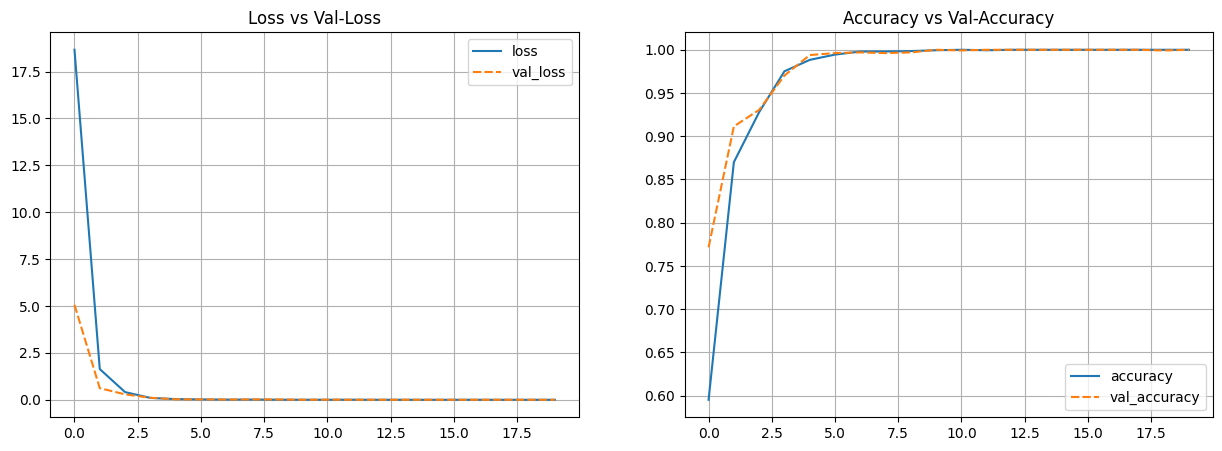

In [53]:
# plot hasil training

history_tl_df = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [54]:
# cek peformance untuk test

# cek probabilitasnya
y_pred_prob_tl = model_tl.predict_generator(test_set_tl)

# kita ubah menjadi label yang sesuai
y_pred_class_tl = np.argmax(y_pred_prob_tl, axis=-1)

# display Classification Report
print(classification_report(test_set_tl.classes, y_pred_class_tl, target_names=np.array(list(train_set_tl.class_indices.keys()))))

                 precision    recall  f1-score   support

bacterialblight       1.00      1.00      1.00       490
      brownspot       1.00      1.00      1.00       483
       leafsmut       1.00      1.00      1.00       433

       accuracy                           1.00      1406
      macro avg       1.00      1.00      1.00      1406
   weighted avg       1.00      1.00      1.00      1406



Berikut beberapa hal yang bisa saya sampaikan terkait hasil model setelah *improvement*.
* Setelah hasil dari penggunaan *transfer learning* dengan **VGG16**, ternyata hasilnya lebih baik dari model awal. Semua nilai dalam metrik *classification report* sempurna 100%.
* Model yang akan saya *saving* adalah model dengan *transfer learning* ini.

# Model Saving
---

In [ ]:
# freeze

# model_tl.trainable=False
# model_tl.summary()

In [64]:
# saving

# model_tl.save('model_cnn_tl.keras')

# Conclusion
---

Sebagai kesimpulan, beberapa hal akan saya sampaikan disini.
1. Awalnya pembagian dataset tidak seperti pada notebook ini, tapi menggunakan *dataframe* yang dipecah sebanyak 2 kali. Lalu setelah di lakukan *training* dan prediksi dengan data *test*, hasilnya sangat *overfitting*. Setelah diberi masukan, ternyata cara pembagian sebelumnya sangat tidak disarankan dan saya menggantinya dengan pembagian yang sekarang ada di notebook ini. Hasilnya sangat berbeda jauh dan sangat baik dari training dan prediksi data *test*-nya.
2. Dari hasil pemodelan dengan cara manual dan menggunakan *transfer learning* menghasilkan prediksi yang bagus namun model yang memakai *transfer learning* memang lebih baik. Maka, model itu yang saya *saving* dan diterapkan dalam *inference*.
3. Dikarenakan datanya yang banyak, ketika menggunakan CPU untuk *running* program setidaknya membutuhkan 7 - 8 menit dalam 1 epoch.
4. Setelah saya cek di **google** terkait penyakit tanaman padi dan karakteristiknya, ada perbedaan dengan dataset yang diberikan. Dalam sebuah sumber mengatakan bahwa leafsmut karakteristikanya seperti titik-titik/area-area kecil yang berwarna hitam dan biasanya banyak dalam satu daun. Jika menggunakan interpretasi dengan dataset ini, artinya *leafsmut* dalam dataset ini adalah *brownspot* yang banyak dalam satu daun. Meskipun begitu, dengan adanya perbedaan interpretasi ini sebenarnya mungkin tidak masalah karena hasil *training* dan prediksinya punya nilai metrik yang bagus. Jika kita ganti datasetnya, kemungkinan model juga bisa beradaptasi.